In [1]:
# Basic Packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Additional Packages
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

random.seed(123)

In [2]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); 

In [3]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Import Data

In [4]:
df = pd.read_excel("data.xlsx")
df = df.dropna(subset = ['label'])
df.drop(columns = ['age'], inplace = True)
df = df.dropna()
df.head(10)

,subject,label,RBC2barrier,Inflation,bandwidth,ven_defect,ven_low,ven_high,ven_SNR,ven_mean,...,rbc_high,rbc_SNR,rbc_mean,rbc_median,rbc_SD,rbc_negative,fvc,fe1,fev1-fvc,fev25-75
16,002-130,IPF,0.30260,2.214508,797.193878,0.020850,0.123779,0.143347,13.261325,0.616582,...,0.066465,3.959749,0.325306,0.295653,0.214930,0.046510,35.8,36.0,100.7,37.7
17,002-130_rep,IPF,0.30260,2.196838,797.193878,0.049093,0.243506,0.102687,9.655796,0.538779,...,0.130581,3.162519,0.390956,0.348991,0.293248,0.064929,35.8,36.0,100.7,37.7
21,003-013A,IPF,0.19224,3.191266,398.596939,0.073045,0.250424,0.073220,8.803432,0.552996,...,0.033407,1.530583,0.192941,0.148458,0.198888,0.217226,56.0,59.0,105.0,76.0
22,003-013B,IPF,0.21894,3.480804,398.596939,0.105445,0.292831,0.068044,8.694271,0.522884,...,0.091593,2.166433,0.267608,0.216779,0.263179,0.158944,49.0,54.0,111.0,96.0
23,003-013B_rep,IPF,0.21894,3.449341,797.193878,0.110928,0.374633,0.051598,4.025500,0.439775,...,0.162216,0.779660,0.384974,0.207698,0.893194,0.259440,49.0,54.0,111.0,96.0
24,003-014,IPF,0.27590,2.176666,797.193878,0.017273,0.145587,0.045019,16.615980,0.564594,...,0.014343,4.754771,0.263845,0.250648,0.168735,0.057259,59.0,60.0,103.0,68.0
25,003-014_rep,IPF,0.27590,2.150269,797.193878,0.015271,0.152853,0.051292,18.134405,0.563476,...,0.007252,5.143344,0.245911,0.227628,0.157435,0.053037,59.0,60.0,103.0,68.0
26,003-014A,IPF,0.27590,2.648010,797.193878,0.032834,0.206419,0.079763,13.653378,0.548241,...,0.013784,3.424738,0.264196,0.248966,0.172329,0.059018,62.0,61.0,98.0,39.0
27,003-014A_rep,IPF,0.27590,2.465210,797.193878,0.037150,0.196026,0.062280,14.746538,0.543239,...,0.016700,4.089562,0.275860,0.259576,0.178420,0.064063,62.0,61.0,98.0,39.0
28,003-014B,IPF,0.26077,2.723907,797.193878,0.086660,0.185957,0.059816,17.600002,0.520253,...,0.000874,4.811945,0.244656,0.239328,0.138342,0.034832,57.0,67.0,106.0,83.0


In [5]:
del df['subject']
label = {'IPF': 1,'NSIP': 0}

df.label = [label[item] for item in df.label]
df.head(10)

,label,RBC2barrier,Inflation,bandwidth,ven_defect,ven_low,ven_high,ven_SNR,ven_mean,ven_median,...,rbc_high,rbc_SNR,rbc_mean,rbc_median,rbc_SD,rbc_negative,fvc,fe1,fev1-fvc,fev25-75
16,1,0.30260,2.214508,797.193878,0.020850,0.123779,0.143347,13.261325,0.616582,0.634848,...,0.066465,3.959749,0.325306,0.295653,0.214930,0.046510,35.8,36.0,100.7,37.7
17,1,0.30260,2.196838,797.193878,0.049093,0.243506,0.102687,9.655796,0.538779,0.544480,...,0.130581,3.162519,0.390956,0.348991,0.293248,0.064929,35.8,36.0,100.7,37.7
21,1,0.19224,3.191266,398.596939,0.073045,0.250424,0.073220,8.803432,0.552996,0.569119,...,0.033407,1.530583,0.192941,0.148458,0.198888,0.217226,56.0,59.0,105.0,76.0
22,1,0.21894,3.480804,398.596939,0.105445,0.292831,0.068044,8.694271,0.522884,0.538891,...,0.091593,2.166433,0.267608,0.216779,0.263179,0.158944,49.0,54.0,111.0,96.0
23,1,0.21894,3.449341,797.193878,0.110928,0.374633,0.051598,4.025500,0.439775,0.426276,...,0.162216,0.779660,0.384974,0.207698,0.893194,0.259440,49.0,54.0,111.0,96.0
24,1,0.27590,2.176666,797.193878,0.017273,0.145587,0.045019,16.615980,0.564594,0.576405,...,0.014343,4.754771,0.263845,0.250648,0.168735,0.057259,59.0,60.0,103.0,68.0
25,1,0.27590,2.150269,797.193878,0.015271,0.152853,0.051292,18.134405,0.563476,0.571920,...,0.007252,5.143344,0.245911,0.227628,0.157435,0.053037,59.0,60.0,103.0,68.0
26,1,0.27590,2.648010,797.193878,0.032834,0.206419,0.079763,13.653378,0.548241,0.555600,...,0.013784,3.424738,0.264196,0.248966,0.172329,0.059018,62.0,61.0,98.0,39.0
27,1,0.27590,2.465210,797.193878,0.037150,0.196026,0.062280,14.746538,0.543239,0.554408,...,0.016700,4.089562,0.275860,0.259576,0.178420,0.064063,62.0,61.0,98.0,39.0
28,1,0.26077,2.723907,797.193878,0.086660,0.185957,0.059816,17.600002,0.520253,0.546030,...,0.000874,4.811945,0.244656,0.239328,0.138342,0.034832,57.0,67.0,106.0,83.0


In [6]:
y = df.label
df_feature = df.loc[:, df.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(df_feature, y, test_size = 0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
X_train

(66, 30) (66,)
(17, 30) (17,)


,RBC2barrier,Inflation,bandwidth,ven_defect,ven_low,ven_high,ven_SNR,ven_mean,ven_median,ven_SD,...,rbc_high,rbc_SNR,rbc_mean,rbc_median,rbc_SD,rbc_negative,fvc,fe1,fev1-fvc,fev25-75
61,0.156373,2.407318,797.193878,0.026596,0.147446,0.114562,10.682585,0.595423,0.616687,0.186912,...,0.050404,2.105929,0.247216,0.203721,0.249782,0.191689,50.0,59.0,118.0,90.0
43,0.279460,3.430206,797.193878,0.178584,0.321341,0.062037,14.011790,0.429964,0.418077,0.233216,...,0.001939,3.261557,0.199209,0.193737,0.128767,0.062384,77.0,76.0,99.0,68.0
64,0.126113,2.114441,797.193878,0.034134,0.170395,0.112967,7.483573,0.577142,0.590071,0.194658,...,0.035895,1.381894,0.230010,0.191392,0.253718,0.209061,42.0,50.0,120.0,117.0
39,0.199360,2.117706,797.193878,0.084057,0.242503,0.101783,6.608916,0.522601,0.536523,0.223315,...,0.074417,1.327632,0.287365,0.210400,0.507003,0.184068,37.0,39.0,105.8,53.1
40,0.300909,3.576447,797.193878,0.054466,0.296920,0.046513,9.657851,0.483358,0.481837,0.182372,...,0.003106,1.848469,0.157020,0.142579,0.131267,0.116577,89.0,80.0,89.5,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.253934,1.690002,797.193878,0.344288,0.474159,0.027105,16.030020,0.283200,0.252031,0.187860,...,0.024396,4.832035,0.297896,0.285109,0.194599,0.019791,39.0,40.0,105.0,54.0
69,0.216270,2.324829,797.193878,0.030441,0.125991,0.153820,20.595295,0.607885,0.622232,0.193349,...,0.001418,6.528709,0.251637,0.254026,0.120706,0.018049,77.0,92.0,119.0,202.0
59,0.109470,2.194916,797.193878,0.009802,0.070534,0.153942,20.307397,0.657915,0.677774,0.159355,...,0.000417,3.516527,0.148855,0.136784,0.119705,0.149034,60.0,68.0,114.0,173.0
95,0.121001,2.524231,797.193878,0.018014,0.144099,0.113246,17.441665,0.595320,0.605936,0.179833,...,0.001173,1.963606,0.117324,0.102200,0.106570,0.185664,78.0,86.0,110.0,122.0


In [7]:
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
rf_model.fit(X_train, y_train)

train_rf_predictions = rf_model.predict(X_train)
train_rf_probs = rf_model.predict_proba(X_train)[:, 1]

rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
print(roc_value)

0.5972222222222222


Recall Baseline: 1.0 Test: 0.78 Train: 1.0
Precision Baseline: 0.53 Test: 0.54 Train: 1.0
Roc Baseline: 0.5 Test: 0.6 Train: 1.0


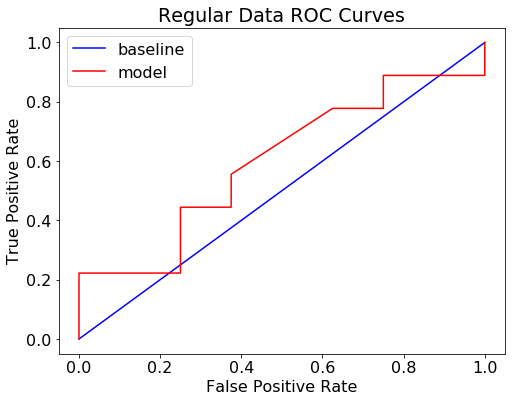

In [8]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.title('Regular Data ROC Curves');

Confusion matrix, without normalization
[[2 6]
 [2 7]]


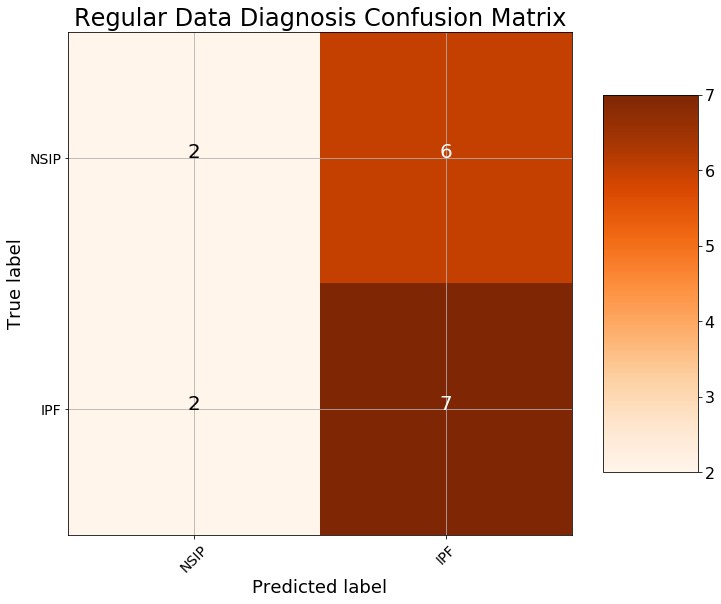

In [9]:
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['NSIP', 'IPF'],
                      title = 'Regular Data Diagnosis Confusion Matrix')

In [10]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
1,Inflation,0.065061
0,RBC2barrier,0.059793
8,ven_median,0.059491
19,rbc_low,0.056607
4,ven_low,0.053981


# Import Features_1 Data

In [11]:
df_features_1 = pd.read_csv("features_1.csv")
df_features_1 = df_features_1.rename(columns={'0.2': 'label'})

labell = {'IPF': 1,'NSIP': 0}
df_features_1.label = [label[item] for item in df_features_1.label]

del df_features_1['0']
del df_features_1['Unnamed: 0']

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df_features_1.head(10)

,0.1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,label
0,0.702200,0.755996,0.690411,0.695222,0.721489,0.763013,0.726244,0.708859,0.319204,0.333998,0.564072,0.628475,0.465415,0.422522,0.646444,0.642391,0.304964,0.213817,0.266239,0.238502,0.693572,0.554325,0.705359,0.613140,1
1,0.824189,0.883184,0.685422,0.757545,0.833337,0.889501,0.709378,0.767727,0.431046,0.396831,0.494768,0.591816,0.551924,0.483105,0.540101,0.592874,0.235739,0.166489,0.191650,0.186050,0.589686,0.452010,0.576240,0.544291,1
2,0.273010,0.519469,0.440704,0.586234,0.235906,0.507057,0.440839,0.575507,0.056350,0.003707,0.141432,0.153341,0.039609,0.000000,0.149435,0.123833,0.432646,0.425856,0.455683,0.470147,0.000000,0.072771,0.200536,0.245756,0
3,0.267187,0.404485,0.262925,0.483532,0.235253,0.381768,0.228785,0.452432,0.304517,0.266018,0.492610,0.547241,0.327676,0.297223,0.376405,0.442841,0.741428,0.649326,0.528208,0.455906,0.002833,0.000000,0.000000,0.000000,0
4,0.349116,0.307190,0.351798,0.337269,0.375364,0.322809,0.382459,0.334092,0.164633,0.132640,0.215497,0.249693,0.344591,0.225253,0.366134,0.298663,0.506650,0.396626,0.461733,0.432464,0.831685,0.891691,0.851181,0.824983,0
5,0.429231,0.485897,0.388516,0.456211,0.445838,0.499880,0.425135,0.470292,0.021324,0.000000,0.026639,0.000000,0.144929,0.057430,0.133460,0.006656,0.769670,0.573155,0.718868,0.642648,0.562013,0.485451,0.628156,0.561523,0
6,0.102337,0.127584,0.138295,0.157983,0.118320,0.128338,0.169867,0.163137,0.179918,0.182139,0.241673,0.264397,0.313055,0.265013,0.360451,0.289010,0.328336,0.248330,0.309574,0.274936,0.592339,0.526571,0.670365,0.572853,0
7,0.457132,0.489901,0.464366,0.504930,0.478555,0.493059,0.508532,0.514622,0.147155,0.060815,0.420396,0.321868,0.318302,0.134000,0.564448,0.373024,0.992639,0.799136,0.880203,0.837914,0.759788,0.894854,0.737921,0.770048,0
8,0.474096,0.463805,0.511610,0.511410,0.486192,0.471139,0.539527,0.522659,0.692434,0.500492,0.692048,0.549680,0.794520,0.598489,0.764666,0.582224,0.311400,0.301213,0.292888,0.317191,0.469959,0.696377,0.566592,0.653472,0
9,0.711706,0.707036,0.553460,0.551844,0.735779,0.717371,0.598930,0.569724,0.157225,0.173771,0.090471,0.094093,0.322439,0.264638,0.218595,0.104570,0.623764,0.440510,0.520320,0.467400,0.668788,0.580663,0.643587,0.581907,0


In [12]:
y = df_features_1.label
df_features_1_features = df_features_1.loc[:, df_features_1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(df_features_1_features, y, test_size = 0.2, random_state = 1)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
X_train

(72, 24) (72,)
(19, 24) (19,)


,0.1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
84,0.908048,0.903897,0.830161,0.888429,0.909561,0.909653,0.841274,0.893178,0.416631,0.253962,0.542974,0.397966,0.544472,0.338976,0.604032,0.409195,0.148040,0.133451,0.129757,0.136135,0.561483,0.664479,0.622095,0.618461
53,0.222885,0.242974,0.194992,0.219974,0.243926,0.254992,0.222351,0.221475,0.335442,0.299542,0.130949,0.167478,0.497434,0.407790,0.213439,0.172605,0.304578,0.268414,0.276071,0.226584,0.581535,0.717495,0.641285,0.497661
19,0.699555,0.680987,0.638652,0.646220,0.708125,0.685865,0.656665,0.656555,0.736720,0.735900,0.848407,0.848795,0.805128,0.795308,0.892340,0.839118,0.285039,0.228405,0.259383,0.261251,0.489708,0.474198,0.557368,0.570272
85,0.694977,0.679526,0.464933,0.486723,0.707309,0.688205,0.495332,0.495298,0.208004,0.132342,0.271101,0.275585,0.351623,0.218862,0.370034,0.306224,0.389080,0.336241,0.357876,0.355353,0.508435,0.617506,0.581235,0.603173
36,0.214251,0.303985,0.340330,0.409530,0.192167,0.300327,0.350924,0.395543,0.122606,0.149030,0.283733,0.328657,0.182968,0.233866,0.356172,0.351553,0.996569,1.000000,1.000000,1.000000,0.295732,0.561016,0.447237,0.509646
33,0.282789,0.287464,0.399153,0.438832,0.287316,0.288190,0.425395,0.449442,0.696885,0.643720,0.917389,0.862768,0.772263,0.719562,0.940809,0.851895,0.179944,0.160490,0.177731,0.187677,0.446386,0.516521,0.587990,0.612686
32,0.404834,0.379020,0.523225,0.516914,0.406029,0.371040,0.552484,0.521589,0.380832,0.408465,0.479831,0.501380,0.460296,0.460696,0.540524,0.508852,0.424205,0.319699,0.414014,0.370134,0.426263,0.347430,0.556509,0.483828
45,0.416017,0.395237,0.265244,0.312756,0.446557,0.411457,0.305150,0.324938,0.344335,0.337571,0.571376,0.601654,0.531577,0.441803,0.681870,0.643640,0.709115,0.529416,0.623582,0.551394,0.568649,0.491086,0.591147,0.513800
66,0.349959,0.370832,0.370386,0.404626,0.343694,0.362675,0.383281,0.397389,0.490044,0.463911,0.726107,0.741494,0.538337,0.496187,0.744190,0.714802,0.409054,0.311639,0.359676,0.327987,0.421952,0.365897,0.462491,0.427608
62,0.197480,0.247643,0.101113,0.149335,0.185593,0.241125,0.089476,0.119204,0.168214,0.204454,0.065586,0.111313,0.224967,0.258045,0.029184,0.037258,0.424739,0.357289,0.355604,0.324665,0.258815,0.264682,0.307335,0.275874


In [13]:
features1_rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
features1_rf_model.fit(X_train, y_train)
features1_rf_predictions = features1_rf_model.predict(X_test)
features1_rf_probs = features1_rf_model.predict_proba(X_test)[:, 1]
train_features1_rf_predictions = features1_rf_model.predict(X_train)
train_features1_rf_probs = features1_rf_model.predict_proba(X_train)[:, 1]
roc_value = roc_auc_score(y_test, features1_rf_probs)
roc_auc_score(y_test, features1_rf_probs)

0.8333333333333334

Recall Baseline: 1.0 Test: 0.77 Train: 1.0
Precision Baseline: 0.68 Test: 0.77 Train: 1.0
Roc Baseline: 0.5 Test: 0.83 Train: 1.0


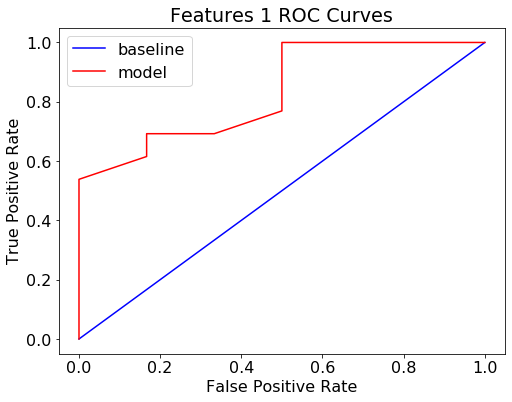

In [14]:
evaluate_model(features1_rf_predictions, features1_rf_probs, train_features1_rf_predictions, train_features1_rf_probs)
plt.title('Features 1 ROC Curves');

Confusion matrix, without normalization
[[ 3  3]
 [ 3 10]]


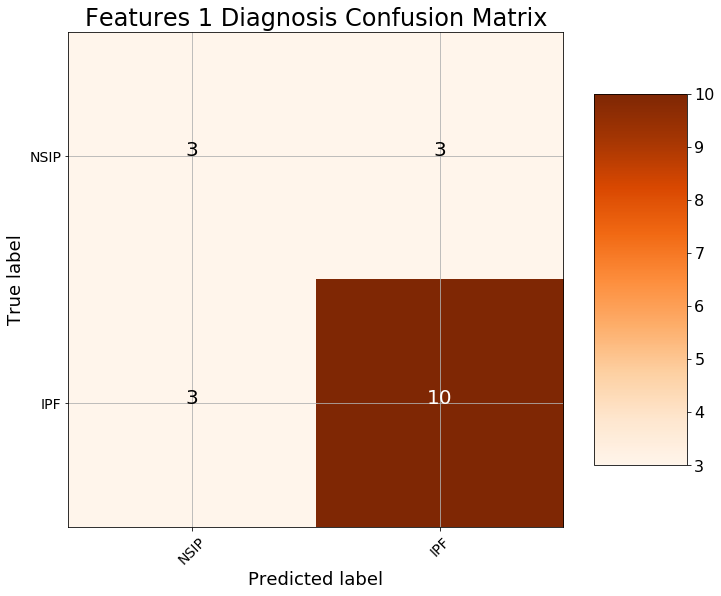

In [15]:
cm = confusion_matrix(y_test, features1_rf_predictions)
plot_confusion_matrix(cm, classes = ['NSIP', 'IPF'],
                      title = 'Features 1 Diagnosis Confusion Matrix')

In [16]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': features1_rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
23,23,0.102184
22,22,0.068310
9,9,0.060039
2,2,0.054266
3,3,0.053879


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
rfc_cv_score = cross_val_score(features1_rf_model, df_features_1_features, y, cv=10, scoring= 'roc_auc')

In [19]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, features1_rf_predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, features1_rf_predictions))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 3  3]
 [ 3 10]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.77      0.77      0.77        13

    accuracy                           0.68        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.68      0.68      0.68        19



=== All AUC Scores ===
[0.875      0.69444444 0.77777778 0.55555556 0.72222222 0.75
 0.55       0.65       0.25       0.5       ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6325000000000001


# Import Features_2 Data

In [20]:
df_features_2 = pd.read_csv("features_2.csv")
df_features_2 = df_features_2.rename(columns={'0.2': 'label'})

label = {'IPF': 1,'NSIP': 0}
df_features_2.label = [label[item] for item in df_features_2.label]

del df_features_2['0']
del df_features_2['Unnamed: 0']

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df_features_2.head(10)

,0.1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,label
0,0.473275,0.789194,0.825564,0.594139,0.728530,0.842741,0.483395,0.800731,0.830742,0.641064,0.775903,0.870997,0.355774,0.241898,0.274646,0.546176,0.752217,0.529212,0.467312,0.329092,0.324779,0.878510,0.796472,0.615958,0.251451,0.241683,0.244475,0.254586,0.264426,0.255719,0.667734,0.705437,0.565111,0.609196,0.683593,0.619897,1
1,0.577715,0.887147,0.788960,0.656464,0.808417,0.784700,0.586137,0.898174,0.775157,0.694289,0.859842,0.797148,0.354765,0.374771,0.433280,0.523067,0.641359,0.538040,0.456749,0.464647,0.403478,0.826746,0.687073,0.562462,0.194275,0.190329,0.143322,0.176913,0.208690,0.179572,0.586040,0.617383,0.284025,0.469259,0.603386,0.420467,1
2,0.471073,0.557991,0.003971,0.644609,0.530311,0.084923,0.431936,0.546350,0.000000,0.651915,0.552938,0.064497,0.022116,0.116538,0.154642,0.136176,0.122540,0.018882,0.000000,0.100267,0.010256,0.238167,0.150221,0.000000,0.329872,0.389147,0.412905,0.400292,0.528588,0.454347,0.109085,0.123465,0.000000,0.151769,0.244986,0.000000,0
3,0.260974,0.431620,0.132613,0.229494,0.499843,0.038944,0.188067,0.397974,0.147250,0.217824,0.506563,0.018996,0.265116,0.301086,0.397133,0.206368,0.620664,0.271481,0.198413,0.269202,0.358794,0.218329,0.595644,0.245399,0.445951,0.526902,0.773646,0.473353,0.569829,0.768366,0.000000,0.000000,0.085084,0.000000,0.000000,0.020566,0
4,0.244607,0.329895,0.416718,0.313439,0.317459,0.525306,0.271935,0.347645,0.460277,0.373353,0.333446,0.556083,0.187214,0.138866,0.121573,0.225763,0.269992,0.050249,0.345586,0.233493,0.216941,0.502527,0.355622,0.192304,0.453377,0.394735,0.440063,0.496749,0.436757,0.418006,0.840559,0.834787,0.792922,0.878742,0.808700,0.744455,0
5,0.357824,0.508732,0.418854,0.378824,0.435547,0.432915,0.363845,0.527454,0.456476,0.426583,0.471697,0.459607,0.000000,0.025996,0.093873,0.000000,0.041120,0.039565,0.075991,0.087807,0.161438,0.089242,0.105351,0.143469,0.646480,0.607376,0.722390,0.622111,0.733222,0.669394,0.576402,0.577655,0.585819,0.485900,0.657331,0.488745,0
6,0.047963,0.137257,0.237754,0.135106,0.115364,0.220677,0.054432,0.147720,0.276779,0.198114,0.124525,0.248112,0.175771,0.255973,0.139799,0.183013,0.303263,0.126869,0.315712,0.349972,0.194489,0.407330,0.371805,0.250319,0.296557,0.258273,0.320776,0.318018,0.293891,0.295300,0.647207,0.603126,0.662844,0.638498,0.603574,0.567871,0
7,0.468788,0.473493,0.422126,0.499523,0.446376,0.483926,0.486371,0.485367,0.466246,0.557519,0.474922,0.520307,0.118847,0.164876,0.193483,0.190598,0.440179,0.117477,0.269300,0.264543,0.283680,0.438251,0.522459,0.254821,0.937529,0.775305,0.926377,0.949091,0.835901,0.854303,0.867857,0.785414,0.825726,0.819041,0.713940,0.726105,0
8,0.296490,0.430045,0.665846,0.297717,0.519228,0.783197,0.308683,0.440567,0.672489,0.357176,0.548031,0.768493,0.539913,0.584865,0.744776,0.378936,0.669001,0.445982,0.687089,0.679208,0.730890,0.674605,0.694632,0.475266,0.316561,0.293347,0.301065,0.335625,0.297514,0.240332,0.651090,0.669027,0.531819,0.641504,0.568164,0.290835,0
9,0.730448,0.686212,0.550377,0.763508,0.597316,0.460829,0.759715,0.698637,0.585859,0.812798,0.642963,0.504912,0.115700,0.309812,0.129830,0.108902,0.266160,0.095359,0.262555,0.418218,0.210441,0.318208,0.350876,0.227289,0.582783,0.419854,0.528597,0.558697,0.490135,0.507152,0.746052,0.545750,0.627637,0.679198,0.590939,0.567675,0


In [21]:
y = df_features_2.label
df_features_2_features = df_features_2.loc[:, df_features_2.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(df_features_2_features, y, test_size = 0.2, random_state = 1)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
X_train

(72, 36) (72,)
(19, 36) (19,)


,0.1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
84,0.897137,0.888394,0.887710,0.894144,0.805031,0.845660,0.908412,0.890944,0.886641,0.919600,0.836596,0.841028,0.357895,0.414614,0.578997,0.350150,0.546957,0.467109,0.511673,0.492190,0.612548,0.611309,0.567146,0.502490,0.146671,0.116315,0.140117,0.155447,0.117879,0.126689,0.671594,0.571403,0.598090,0.658536,0.519726,0.498825
53,0.180091,0.241348,0.198368,0.150869,0.210281,0.329082,0.194917,0.255096,0.242636,0.212746,0.223601,0.350573,0.257834,0.296113,0.452414,0.108497,0.177273,0.200045,0.410603,0.397892,0.497038,0.279265,0.234252,0.281725,0.287400,0.268730,0.269662,0.263867,0.272531,0.226763,0.680065,0.723866,0.561890,0.561725,0.620556,0.366010
19,0.639783,0.655031,0.645975,0.483179,0.630938,0.714113,0.643809,0.663769,0.671017,0.525874,0.664888,0.740147,0.718864,1.000000,0.776935,0.635004,1.000000,0.748480,0.810889,1.000000,0.809244,0.919920,1.000000,0.800663,0.248342,0.206072,0.294158,0.247354,0.250328,0.256824,0.545942,0.434976,0.596405,0.492981,0.498700,0.456326
85,0.689994,0.703686,0.545718,0.594688,0.463733,0.270959,0.715242,0.716379,0.565135,0.643467,0.489283,0.296038,0.173717,0.173718,0.317366,0.186859,0.324012,0.201472,0.322716,0.259688,0.352136,0.429100,0.383147,0.268267,0.388149,0.334309,0.348220,0.427221,0.347528,0.322174,0.669754,0.632931,0.486942,0.698518,0.546374,0.405381
36,0.249475,0.251412,0.274655,0.392681,0.343965,0.371064,0.244217,0.247860,0.278599,0.436471,0.344721,0.360510,0.140241,0.124357,0.202426,0.215392,0.259582,0.191173,0.238917,0.194338,0.206239,0.408272,0.303020,0.259472,0.981016,1.000000,1.000000,0.889791,1.000000,1.000000,0.490248,0.577547,0.392278,0.362470,0.437433,0.376008
33,0.271676,0.270680,0.290900,0.340765,0.379259,0.507841,0.281029,0.275269,0.325472,0.386045,0.401624,0.527555,0.575666,0.590267,0.832064,0.626532,0.832643,0.712720,0.719447,0.654775,0.816400,0.917395,0.852934,0.733708,0.191368,0.171727,0.181427,0.173150,0.189626,0.187066,0.631642,0.616602,0.526901,0.513930,0.607529,0.550579
32,0.249366,0.383386,0.562319,0.436106,0.442494,0.647008,0.228482,0.389735,0.573405,0.458511,0.470318,0.669296,0.338613,0.365173,0.393476,0.348403,0.533194,0.378560,0.377322,0.434009,0.407181,0.488181,0.576633,0.465831,0.338648,0.386290,0.375386,0.329032,0.434875,0.393174,0.442478,0.599075,0.373458,0.373298,0.588141,0.403245
45,0.308036,0.384290,0.396228,0.354357,0.299706,0.262907,0.331760,0.402898,0.438355,0.421255,0.327065,0.304865,0.252132,0.313591,0.286286,0.307347,0.739438,0.556213,0.421123,0.418233,0.370493,0.602646,0.793157,0.673489,0.664557,0.533769,0.602914,0.705986,0.557508,0.594960,0.668561,0.541224,0.488819,0.678688,0.472048,0.473829
66,0.135309,0.422878,0.661709,0.232126,0.397995,0.681027,0.099317,0.426806,0.696096,0.252060,0.415709,0.717843,0.407686,0.553175,0.623400,0.382826,0.848609,0.820741,0.397502,0.611421,0.684826,0.534768,0.880374,0.884573,0.270248,0.346708,0.479988,0.269211,0.353876,0.401761,0.330899,0.517477,0.674827,0.283910,0.425072,0.469123
62,0.203674,0.253440,0.323087,0.095462,0.164257,0.210093,0.198871,0.249443,0.358722,0.110180,0.151789,0.195502,0.208626,0.230397,0.447370,0.036252,0.092689,0.158453,0.304007,0.262065,0.466799,0.013653,0.089254,0.160578,0.373659,0.384645,0.426670,0.305278,0.374153,0.346421,0.370695,0.409192,0.316337,0.238250,0.294572,0.106683


In [22]:
features2_rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
features2_rf_model.fit(X_train, y_train)
features2_rf_predictions = features2_rf_model.predict(X_test)
features2_rf_probs = features2_rf_model.predict_proba(X_test)[:, 1]
train_features2_rf_predictions = features2_rf_model.predict(X_train)
train_features2_rf_probs = features2_rf_model.predict_proba(X_train)[:, 1]
roc_value = roc_auc_score(y_test, features2_rf_probs)
roc_auc_score(y_test, features2_rf_probs)

0.7692307692307693

Recall Baseline: 1.0 Test: 0.77 Train: 1.0
Precision Baseline: 0.68 Test: 0.83 Train: 1.0
Roc Baseline: 0.5 Test: 0.77 Train: 1.0


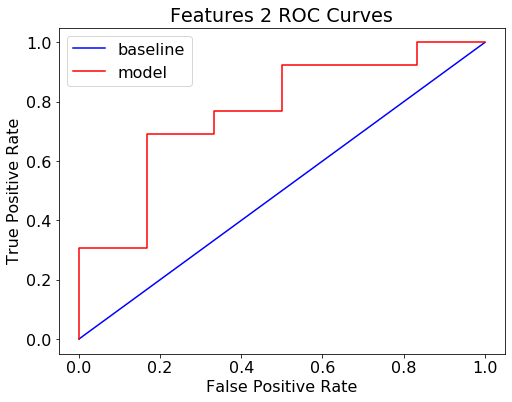

In [23]:
evaluate_model(features2_rf_predictions, features2_rf_probs, train_features2_rf_predictions, train_features2_rf_probs)
plt.title('Features 2 ROC Curves');

Confusion matrix, without normalization
[[ 4  2]
 [ 3 10]]


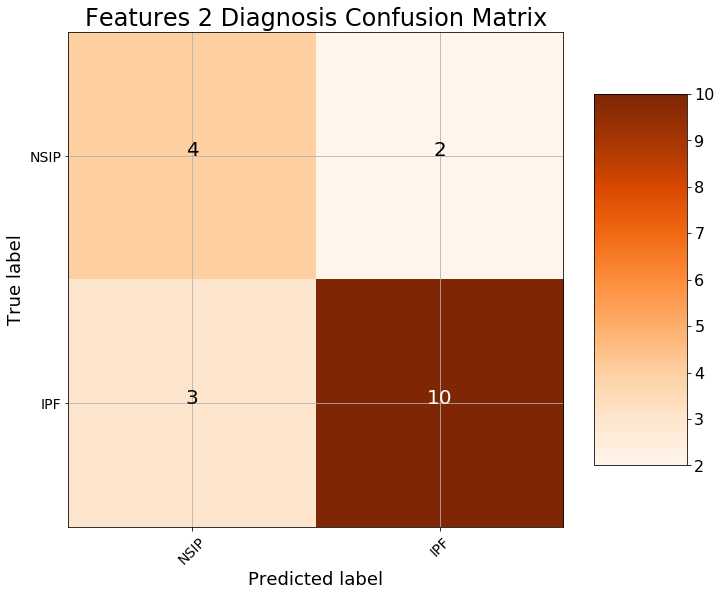

In [24]:
cm = confusion_matrix(y_test, features2_rf_predictions)
plot_confusion_matrix(cm, classes = ['NSIP', 'IPF'],
                      title = 'Features 2 Diagnosis Confusion Matrix')

In [25]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': features2_rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
34,34,0.075219
17,17,0.058377
12,12,0.041794
23,23,0.041728
3,3,0.041728


In [26]:
rfc_cv_score = cross_val_score(features2_rf_model, df_features_2_features, y, cv=10, scoring= 'roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, features1_rf_predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, features1_rf_predictions))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 3  3]
 [ 3 10]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.77      0.77      0.77        13

    accuracy                           0.68        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.68      0.68      0.68        19



=== All AUC Scores ===
[0.6875     0.61111111 0.94444444 0.44444444 0.77777778 0.55
 0.4        0.725      0.525      0.45      ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6115277777777778
